# Reinforcement Learning on FrozenLake 

### Code part

Import all necessary function that will be use in this project

In [43]:
# Import all necessary library
import gym
import numpy as np
import time
import random
from bisect import bisect
from IPython.display import clear_output
import matplotlib.pyplot as plt

## Define functions

In [70]:
# Function for calculating probability of action by using epsilon-greedy
def calculate_prob(env, max_action, epsilon):
    action_prob=[]
    maxcount=0
    for a in range(env.action_space.n):
        if(a == max_action):
            prob=1-epsilon+(epsilon/env.action_space.n)
            action_prob.append(prob)
        else:
            prob=epsilon/env.action_space.n
            action_prob.append(prob)
    
    return action_prob

# Function for randomizing choices with weighted probabilities
def weighted_prob(choices):
    values, weights = zip(*choices)
    total = 0
    cum_weights = []
    for w in weights:
        total += w
        cum_weights.append(total)
    x = random.random() * total
    i = bisect(cum_weights, x)
    return values[i]

# Function for printing the current policy to the screen
def print_policy(policy):
    left = '←'
    up = '↑'
    down = '↓'
    right = '→'
    
    string=""
    key=''
    if(len(policy)==16):
        for i in range(len(policy)):
            if i not in (5,7,11,12,15):
                if(policy[i]==0):
                    key = left
                elif(policy[i]==1):
                    key = down
                elif(policy[i]==2):
                    key = right
                elif(policy[i]==3):
                    key = up
            else:
                if(i == 15):
                    key = 'G'
                else:
                    key = 'H'
            string = string+key
            if(i%4 == 3):
                print(string)
                string=""
            
    else:
        for i in range(len(policy)):
            if i not in (19,29,35,41,42,46,49,52,54,59,63):
                if(policy[i]==0):
                    key = left
                elif(policy[i]==1):
                    key = down
                elif(policy[i]==2):
                    key = right
                elif(policy[i]==3):
                    key = up
            else:
                if( i == 63):
                    key = 'G'
                else:
                    key = 'H'
            string = string+key
            if(i%8 == 7):
                print(string)
                string=""


# This function acts greedily on the Q table to get the policy 
def get_optimal_policy(Q_table):
    left = 0
    up = 3
    down = 1
    right = 2
    actions=[]
    if(len(Q_table) == 16):
        for state in range(len(Q_table)):
            if state not in (5,7,11,12,15):
                best_action = np.argmax(Q_table[state,:])
                if(best_action==0):
                    best_action = left
                elif(best_action==1):
                    best_action = down
                elif(best_action==2):
                    best_action = right
                else:
                    best_action = up
            else:
                if(state == 15):
                    best_action = 'G'
                else:
                    best_action = 'H'

            actions.append(best_action)
    else:
        for state in range(len(Q_table)):
            if state not in (19,29,35,41,42,46,49,52,54,59,63):
                best_action = np.argmax(Q_table[state,:])
                if(best_action==0):
                    best_action = left
                elif(best_action==1):
                    best_action = down
                elif(best_action==2):
                    best_action = right
                else:
                    best_action = up
            else:
                if(state == 63):
                    best_action = 'G'
                else:
                    best_action = 'H'

            actions.append(best_action)
            
    return actions


# This function renders the agent interacting with the env under the input policy
def test_policy(policy, env):
    observation = env.reset()
    env.render()
    clear_output(wait=True)
    done = False
    while not done:
        action = policy[observation]
        observation, reward, done, info = env.step(action)
        env.render()
        if(done == True):
            action = policy[observation]
            if(action == 'H'):
                print()
                print("LOST")
                print("TRY AGAIN")
                break
            elif(action == 'G'):
                print()
                print("WON")
                print("WELL DONE")
                break
        clear_output(wait=True)
        time.sleep(0.1)

## 1. Sarsa(Lamda)

In [45]:
# Sarsa(Lambda)
# Action space = [0:left,1:down,2:right,3:up]
def Sarsa_Lambda(env, num_episodes=10000):
    Q = np.zeros([env.observation_space.n,env.action_space.n]) # Action Value
    E = np.zeros([env.observation_space.n,env.action_space.n]) # Eligibility Trace


    # Set up parameters
    EPSILON = 0.01
    DELTA = 0
    GAMMA = 1
    ALPHA = 0.1
    LAMBDA = 0.55

    policy = dict(left=0.25,down=0.25,right=0.25,up=0.25)


    win_history = []
    num_win = 0
    for episode in range( num_episodes ):
    #     EPSILON = 1/(episode+1)
        state = env.reset()
        action = np.argmax(Q[state,:] + np.random.randn(1,env.action_space.n)*(1./(episode+1)))
        done = False

        while not done:
            
            next_state, reward, done, info = env.step(action) 
            
            # Choose action from action-value function
            max_action_next_state = np.argmax(Q[next_state,:] + np.random.randn(1,env.action_space.n)*(1./(episode+1)))
            # Calculate the probability for selecting actions using epsilongreedy
            action_probability=calculate_prob(env,max_action_next_state, EPSILON)
            # Random select action base on previous probability 
            next_action=np.random.choice([0,1,2,3], p=action_probability)


            DELTA = reward + GAMMA*Q[next_state, next_action] - Q[state, action]
            E[state, action] = E[state, action] + 1
            for each_state in range(env.observation_space.n):
                for each_action in range(env.action_space.n):
                    Q[each_state, each_action] = Q[each_state, each_action] + ALPHA*DELTA*E[each_state, each_action]
                    E[each_state, each_action] = GAMMA*LAMBDA*E[each_state, each_action]

            state = next_state
            action = next_action


        num_win = num_win+reward
        win_history.append(num_win/(episode+1))
    
    policy = get_optimal_policy(Q)
    
    return policy, win_history[-1], win_history


### 2. Sarsa(on-policy TD control)

In [46]:
# Sarsa(on-policy TD control)
# Action space = [0:left,1:down,2:right,3:up]

def Sarsa_Normal(env, num_episodes=10000):
    Q = np.zeros([env.observation_space.n,env.action_space.n]) # Action Value


    # Set up parameters
    EPSILON = 0.1
    GAMMA = 1
    ALPHA = 0.85

    policy = dict()

    win_history = []
    num_win = 0
    for episode in range( num_episodes ):
        EPSILON = 1/(episode+1)
        state = env.reset()
        
        
        # Choose action from action-value function
        max_action = np.argmax(Q[state,:] + np.random.randn(1,env.action_space.n)*(1./(episode+1)))
        # Calculate the probability for selecting actions using epsilongreedy
        action_probability=calculate_prob(env,max_action, EPSILON)
        # Random select action base on previous probability 
        action = np.random.choice([0,1,2,3], p=action_probability)
            
        done = False

        while not done:
    #         env.render()

            next_state, reward, done, info = env.step(action) 

            # Choose action from action-value function
            max_action_next_state = np.argmax(Q[next_state,:] + np.random.randn(1,env.action_space.n)*(1./(episode+1)))
            # Calculate the probability for selecting actions using epsilongreedy
            action_probability=calculate_prob(env,max_action_next_state, EPSILON)
            # Random select action base on previous probability 
            next_action=np.random.choice([0,1,2,3], p=action_probability)


            Q[state, action] = Q[state, action] + ALPHA*(reward+GAMMA*Q[next_state, next_action] - Q[state, action])

            state = next_state
            action = next_action

        num_win = num_win+reward
        win_history.append(num_win/(episode+1))
    
    policy = get_optimal_policy(Q)
    
    return policy, win_history[-1], win_history
        


### 3. Q-Learning

In [47]:
# Q_Learning (Off-policy TD Control)

def Q_Learning(env, episode=10000):
    # Load Environment from Gym and initial action-value function table
    Q = np.zeros([env.observation_space.n,env.action_space.n])

    win_history=[]
    alpha = .68
    gamma = .9
    retern_list = [] # rewards per episode calculate
    reach_goal_count=0


    for i in range(episode):
        # Calculate epsilon for using in epsilon-greedy
        epsilon=1/(i+1)

        # Reset environment
        s = env.reset()

        reward = 0
        d = False
        j = 0
        goal=(int)(env.observation_space.n)-1
        # The Q-learning algorithm
        # Loop until reach the goal
        while(s!=goal):

    #         env.render()
            j+=1

            # Choose action from action-value function
            max_a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
            # Calculate the probability for selecting actions using epsilongreedy
            action_probability=calculate_prob(env,max_a, epsilon)
            # Random select action base on previous probability 
            a=np.random.choice([0,1,2,3], p=action_probability)

            # Take action and get new state & reward from environment
            s1,r,d,_ = env.step(a)

            #Update the action-valuse function
            Q[s,a] = Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]) - Q[s,a])
            reward += r
            if(s1==goal):
                reach_goal_count+=1
            s = s1
            if d == True:
                break


        # Collect win history        
        win_history.append(reach_goal_count/(i+1))      
        retern_list.append(reward)
        
    policy = get_optimal_policy(Q)
    
    return policy, win_history[-1], win_history 
       


### 4. MC Control

In [48]:
# MC Control

# Function to generate random policy at initial        
def generate_random_policy(env):
    policy = {}
    for key in range(0, env.observation_space.n):
        current_end = 0
        p = {}
        for action in range(0, env.action_space.n):
            p[action] = 1 / env.action_space.n
        policy[key] = p

    return policy   

# Function to generate each episode
def generate_episode(env, policy):
    env.reset()
    episode = []
    finished = False
    
    while not finished:
        s = env.env.s
        timestep = []
        n = random.uniform(0, sum(policy[s].values()))
        top_range = 0

        for prob in policy[s].items():
            top_range += prob[1]
            if n < top_range:
                action = prob[0]
                break   
        
        state, reward, finished, info =  env.step(action)
        timestep.append(state)
        timestep.append(action)
        timestep.append(reward)
        
        
        episode.append(timestep)

    return episode

# Function to evaluate the final policy
def evaluate_policy(policy,env):
    wins = 0
    r = 20000
    win_history=[]
    for i in range(r):
        w = generate_episode(env, policy)[-1][0]
        if w == env.observation_space.n-1:
            wins += 1
        win_history.append(wins/r)
        
    plt.plot(win_history)
    plt.axis([0, r, 0, 1.1])
    plt.show()
    print("Win rate of MC Control algorithm is ",win_history[r-1]," with running",r," episodes")
    
def get_MC_policy(policy):
    max_action=[]
    for i in policy.items():
#         print(i[1])
        max_value=max(i[1].values())
        for j in i[1].items():
            if(j[1]==max_value):
                max_action.append(j[0])
                break
    return(max_action)

def MC_Control(env, episode=10000):
    Q = np.zeros([env.observation_space.n,env.action_space.n])

    # env.obeservation.n, env.action_space.n gives number of states and action in env loaded
    # Defind an important parameters 
    win_history=[]
    retern_list = [] # rewards per episode calculate
    reach_goal_count=0

    policy = generate_random_policy(env)
    returns={}

    num_win= 0
    for i in range(episode):
        # Calculate epsilon for using in epsilon-greedy
        epsilon=1/(i+1)

        G=0
        this_episode=generate_episode(env, policy)
        # Reset environment
        s = env.reset()


        for j in reversed(range(0, len(this_episode))): # 7.
                s, a, r = this_episode[j] # 8. 
                state_action = (s, a)
                G += r

                if not state_action in [(x[0], x[1]) for x in this_episode[0:j]]: # 10.
                    if returns.get(state_action):
                        returns[state_action].append(G)
                    else:
                        returns[state_action] = [G]   

                    Q[s,a] = sum(returns[state_action]) / len(returns[state_action])

                    # Choose action from action-value function
                    max_a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(j+1)))
                    # Calculate the probability for selecting actions using epsilongreedy

                    for a in policy[s].items(): # 15.
                        if a[0] == max_a:
                            policy[s][a[0]] = 1 - epsilon + (epsilon / env.action_space.n)
                        else:
                            policy[s][a[0]] = (epsilon / env.action_space.n)

        num_win = num_win+this_episode[-1][-1]
        win_history.append((num_win/(i+1)))
    policy = get_MC_policy(policy)    
    return policy, win_history[-1], win_history

### Implement all algorithm

In [76]:
env1a = gym.make('FrozenLake-v0')
policy1a, win_rate1a, win_history1a = Sarsa_Lambda(env1a, 20000)
print("DONE")

DONE


In [77]:
env1b = gym.make('FrozenLake8x8-v0')
policy1b, win_rate1b, win_history1b = Sarsa_Lambda(env1b, 20000)
print("DONE")

DONE


In [78]:
env2a = gym.make('FrozenLake-v0')
policy2a, win_rate2a, win_history2a = Sarsa_Normal(env2a, 20000)
print("DONE")

DONE


In [79]:
env2b = gym.make('FrozenLake8x8-v0')
policy2b, win_rate2b, win_history2b = Sarsa_Normal(env2b, 20000)
print("DONE")

DONE


In [80]:
env3a = gym.make('FrozenLake-v0')
policy3a, win_rate3a, win_history3a = Q_Learning(env3a, 20000)
print("DONE")

DONE


In [81]:
env3b = gym.make('FrozenLake8x8-v0')
policy3b, win_rate3b, win_history3b = Q_Learning(env3b, 20000)
print("DONE")

DONE


In [82]:
env4a = gym.make('FrozenLake-v0')
policy4a, win_rate4a, win_history4a = MC_Control(env4a, 20000)
print("DONE")

DONE


In [83]:
env4b = gym.make('FrozenLake8x8-v0')
policy4b, win_rate4b, win_history4b = MC_Control(env4b, 20000)
print("DONE")

DONE


In [73]:
test_policy(policy4a,env4a)

  (Up)
SFFF
FHFH
FFFH
HFFG


# Performance Comparison

# 4x4 Grid

In [96]:
print("4x4 Sarsa(Lambda) Win Rate : "+str(win_rate1a))
print("4x4 Normal Sarsa Win Rate : "+str(win_rate2a))
print("4x4 Q-Learning Win Rate : "+str(win_rate3a))
print("4x4 MC Control Win Rate : "+str(win_rate4a))

4x4 Sarsa(Lambda) Win Rate : 0.543
4x4 Normal Sarsa Win Rate : 0.69695
4x4 Q-Learning Win Rate : 0.60055
4x4 MC Control Win Rate : 0.02495


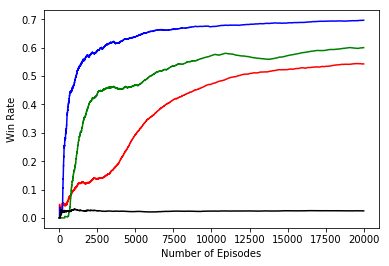

In [94]:
plt.plot(win_history1a,'r')
plt.plot(win_history2a,'b')
plt.plot(win_history3a,'g')
plt.plot(win_history4a,'black')
plt.ylabel('Win Rate')
plt.xlabel('Number of Episodes')
plt.show()

In [98]:
# 4x4 Sarsa(Lambda)
test_policy(policy1a,env1a)

  (Down)
SFFF
FHFH
FFFH
HFFG

WON
WELL DONE


In [99]:
# 4x4 Normal Sarsa
test_policy(policy2a,env2a)

  (Down)
SFFF
FHFH
FFFH
HFFG

WON
WELL DONE


In [105]:
# 4x4 Q-Learning
test_policy(policy3a,env3a)

  (Down)
SFFF
FHFH
FFFH
HFFG

WON
WELL DONE


In [104]:
# 4x4 MC Control
test_policy(policy4a,env4a)

  (Left)
SFFF
FHFH
FFFH
HFFG


# 8x8 Grid

In [97]:
print("8x8 Sarsa(Lambda) Win Rate : "+str(win_rate1b))
print("8x8 Normal Sarsa Win Rate : "+str(win_rate2b))
print("8x8 Q-Learning Win Rate : "+str(win_rate3b))
print("8x8 MC Control Win Rate : "+str(win_rate4b))

8x8 Sarsa(Lambda) Win Rate : 0.35035
8x8 Normal Sarsa Win Rate : 0.39935
8x8 Q-Learning Win Rate : 0.60805
8x8 MC Control Win Rate : 0.2461


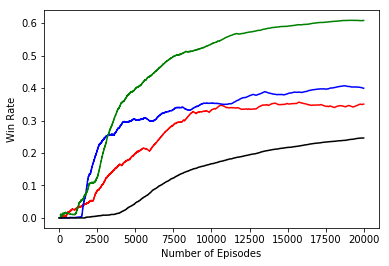

In [95]:
plt.plot(win_history1b,'r')
plt.plot(win_history2b,'b')
plt.plot(win_history3b,'g')
plt.plot(win_history4b,'black')
plt.ylabel('Win Rate')
plt.xlabel('Number of Episodes')
plt.show()

In [106]:
# 8x8 Sarsa(Lambda)
test_policy(policy1b,env1b)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

WON
WELL DONE


In [107]:
# 8x8 Normal Sarsa
test_policy(policy2b,env2b)

  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [108]:
# 8x8 Q-Learning
test_policy(policy3b,env3b)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

WON
WELL DONE


In [110]:
# 8x8 MC Control
test_policy(policy4b,env4b)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


# Summary

# Learnings Gained From The Project

From our project, we learnt that the performance of each algorithm depends on not only the adjusted parameters but also the pattern and the size of the environment. The same algorithm may behave differently under the same environment with different sizes. An algorithm that performs best on one environment may perform not as good on the others.

# Knowledge Sources

https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0
    
https://harderchoices.com/2018/04/04/monte-carlo-method-in-python/

https://towardsdatascience.com/reinforcement-learning-with-openai-d445c2c687d2

http://deeplizard.com/learn/video/HGeI30uATws


# Members

Sakpat Sirikanerat 1900549

Nuttapol Saiboonrue 1900552